In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from enum import Enum

class Resolution(Enum):
    P1080 = 1080,
    P1440 = 1440


def process_image(path, resolution=Resolution.P1080):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sub_images = []
    
    if resolution == Resolution.P1080:
        cropped_image = image[200:400, 775:975]

        for y_start in [0, 120]:
            for x_start in [0, 135]:
                # First crop, get entire dice with circle around it
                sub_image = cropped_image[y_start:y_start+75, x_start:x_start+75]
                sub_image = cv2.resize(sub_image, (100, 100))
                # Second crop, remove circle around dice
                sub_image = sub_image[20:80, 20:80]
                sub_images.append(sub_image)
    elif resolution == Resolution.P1440:
        # Pozycje kości w 1440p:
        # 1050:1110, 290:345
        # 1050:1110, 447:504
        # 1228:1292, 290:345
        # 1228:1292, 447:504
        for y_start in [290, 448]:
            for x_start in [1050, 1230]:
                sub_image = image[y_start:y_start+57, x_start:x_start+62]
                sub_image = cv2.resize(sub_image, (100, 100))
                sub_images.append(sub_image)
    
    return sub_images

In [7]:
def threshold_image(gray):
    threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return threshed

In [8]:
def count_dots_v2(threshed, image):
    cnts = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 500:
            cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kernel, iterations=3)
    
    # Find circles 
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area > 20 and area < 50:
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.circle(image, (int(x), int(y)), int(r), (36, 255, 12), 2)
            
    rand = np.random.randint(0, 1000)
    cv2.imwrite(f"out/circles{rand}.png", image)
    
    return len(cnts)

Enemy dices: 10
Player dices: 8


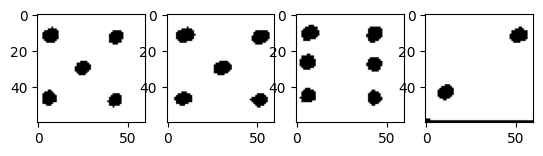

In [9]:
resolution = Resolution.P1080   # Config
dices = process_image("data/ref_loss.png", resolution)
enemy_dices = 0
player_dices = 0

for i in range(2):
    thresh = threshold_image(dices[i])
    plt.subplot(1,4,i+1)
    plt.imshow(thresh, cmap='binary')
    dots = count_dots_v2(thresh, dices[i])
    enemy_dices += dots

for i in range(2, 4):
    thresh = threshold_image(dices[i])
    plt.subplot(1,4,i+1)
    plt.imshow(thresh, cmap='binary')
    dots = count_dots_v2(thresh, dices[i])
    player_dices += dots

print("Enemy dices:", enemy_dices)
print("Player dices:", player_dices)

Enemy dices: 7
Player dices: 4


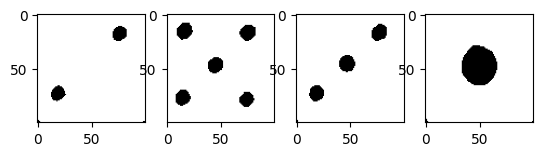

In [10]:
resolution = Resolution.P1440   # Config
dices = process_image("data/massfun.png", resolution)
enemy_dices = 0
player_dices = 0

for i in range(2):
    thresh = threshold_image(dices[i])
    plt.subplot(1,4,i+1)
    plt.imshow(thresh, cmap='binary')
    dots = count_dots_v2(thresh, dices[i])
    enemy_dices += dots

for i in range(2, 4):
    thresh = threshold_image(dices[i])
    plt.subplot(1,4,i+1)
    plt.imshow(thresh, cmap='binary')
    dots = count_dots_v2(thresh, dices[i])
    player_dices += dots

print("Enemy dices:", enemy_dices)
print("Player dices:", player_dices)